In [1]:
# Author: Srijith Rajamohan based off the work by Robert Guthrie
# Source: 
# https://srijithr.gitlab.io/post/word2vec/

In [2]:
import os
from IPython.display import Image

In [5]:
pth = os.getcwd()
pth

'/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/NLPstudy'

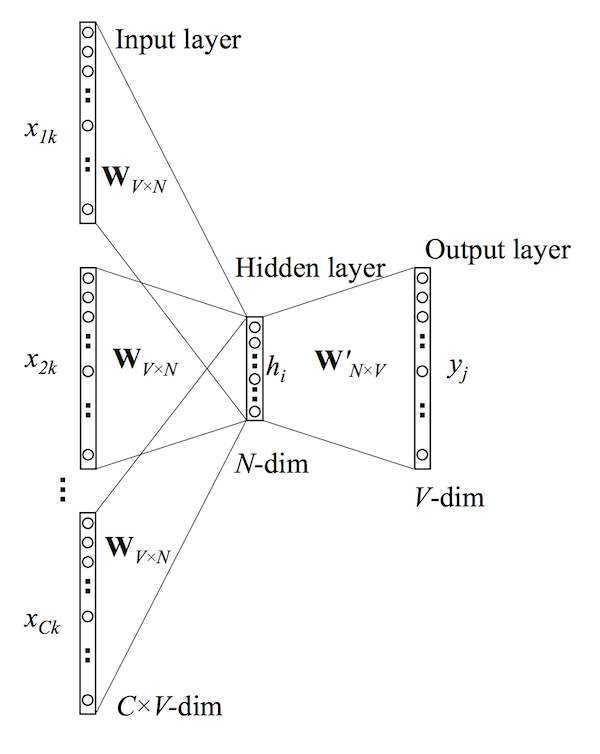

In [7]:

Image(filename=pth + '/CBOWModel/images/Cbow.png')

In [72]:
import torch
import torch.tensor as Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import urllib.request
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

torch.manual_seed(1)

In [11]:
CONTEXT_SIZE = 3
EMBEDDING_DIM = 10

testSentence = """Empathy for the poor may not come easily to people who never experienced it. 
They may blame the victims and insist their predicament can be overcome through determination 
and hard work.
But they may not realize that extreme poverty can be psychologically and physically 
incapacitating — a perpetual cycle of bad diets, health care and education exacerbated 
by the shaming and self-fulfilling prophecies that define it in the public imagination.
Gordon Parks — perhaps more than any artist — saw poverty as “the most savage of all human 
afflictions” and realized the power of empathy to help us understand it. It was neither an 
abstract problem nor political symbol, but something he endured growing up destitute in rural 
Kansas and having spent years documenting poverty throughout the world, including the United 
States.
That sensitivity informed “Freedom’s Fearful Foe: Poverty,” his celebrated photo essay published
 in Life magazine in June 1961. He took readers into the lives of a Brazilian boy, Flavio 
 da Silva, and his family, who lived in the ramshackle Catacumba favela in the hills outside 
 Rio de Janeiro. These stark photographs are the subject of a new book, “Gordon Parks: The
  Flavio Story” (Steidl/The Gordon Parks Foundation), which accompanies a traveling exhibition 
  co-organized by the Ryerson Image Centre in Toronto, where it opens this week, and 
  the J. Paul Getty Museum. Edited with texts by the exhibition’s co-curators, Paul Roth and 
  Amanda Maddox, the book also includes a recent interview with Mr. da Silva and essays by 
  Beatriz Jaguaribe, Maria Alice Rezende de Carvalho and Sérgio Burgi.
""".split()


# we should tokenize the input, but we will ignore that for now


# Building NGRAMS: build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
ngrams = []
for i in range(len(testSentence) - CONTEXT_SIZE):
    tup = [testSentence[j] for j in np.arange(i, i + CONTEXT_SIZE)]
    ngrams.append( (tup, testSentence[i + CONTEXT_SIZE]) )


# Creating vocabulary
vocabulary = set(testSentence)

# Creating word to index map: 
wordToIndex = {word : i for i, word in enumerate(vocabulary)}

In [18]:
print(len(ngrams))
print("ngrams: ", ngrams[:10])

print(len(vocabulary))

print(len(wordToIndex))
print("\nwordToIndex: ", wordToIndex)

256
ngrams:  [(['Empathy', 'for', 'the'], 'poor'), (['for', 'the', 'poor'], 'may'), (['the', 'poor', 'may'], 'not'), (['poor', 'may', 'not'], 'come'), (['may', 'not', 'come'], 'easily'), (['not', 'come', 'easily'], 'to'), (['come', 'easily', 'to'], 'people'), (['easily', 'to', 'people'], 'who'), (['to', 'people', 'who'], 'never'), (['people', 'who', 'never'], 'experienced')]
195
195

wordToIndex:  {'(Steidl/The': 0, 'sensitivity': 1, 'Foe:': 2, 'week,': 3, 'saw': 4, 'Gordon': 5, 'an': 6, 'States.': 7, 'It': 8, 'health': 9, 'afflictions”': 10, 'J.': 11, 'hills': 12, 'artist': 13, 'any': 14, 'bad': 15, 'people': 16, 'Toronto,': 17, 'But': 18, 'Carvalho': 19, 'victims': 20, 'work.': 21, 'help': 22, 'for': 23, 'includes': 24, 'education': 25, 'Museum.': 26, 'more': 27, 'Alice': 28, 'texts': 29, 'us': 30, 'he': 31, '“Freedom’s': 32, 'Story”': 33, 'predicament': 34, 'political': 35, 'Image': 36, 'Mr.': 37, 'Beatriz': 38, 'destitute': 39, 'exhibition’s': 40, 'extreme': 41, 'celebrated': 42, '

In [19]:
def printKey(iWord, wordToIndexDict):
    """
    Prints the key (the word) corresponding to the given index in the given dictionary. 
    
    :param iWord: index of a word in the given dict
    :param wordToIndexDict: the dictionary 
    :return: key 
    """
    for key, index in wordToIndexDict.items():
        if(index == iWord):
            print(key)
            


def clusterEmbeddings(filename, numClusters):
    X = np.load(filename)
    kmeans = KMeans(n_clusters=numClusters, random_state=  0).fit(X) # from sklearn
    center = kmeans.cluster_centers_
    distances = euclidean_distances(X, center)
    
    for i in np.arange(0, distances.shape[1]):
        
        # get the index of the minimum distance in the ith row of the dist matrix
        iMinWord = np.argmin(distances[:, i])
        print(iMinWord)
        printKey(iWord=iMinWord, wordToIndexDict= wordToIndex)
        

def readData(filePath):
    tokenizer = RegexpTokenizer(r'\w+')
    data = urllib.request.urlopen(filePath)
    data = data.read().decode('utf8')
    tokenizedData = word_tokenize(data)
    
    # note: stopwords are from nltk
    stopWordsSet = set(stopwords.words('english'))
    stopWordsSet.update(['.',',',':',';','(',')','#','--','...','"'])
    cleanedWords = [word for word in tokenizedData if word not in stopWordsSet]
    
    return cleanedWords


In [77]:
class CBOWModeler(nn.Module):
    
    def __init__(self, vocabSize: int, embeddingDim: int, contextSize: int):
        """
        
        :param vocabSize: size of vocabulary dict 
        :param embeddingDim: largest length of the embedding vectors 
        :param contextSize: context window size (num words to include as context around target)
        
        """
        super(CBOWModeler, self).__init__()
        
        # see docs: https://hyp.is/cv2pSAeqEeqIRHv7JAjgtA/pytorch.org/docs/stable/nn.html
        # num_embeddings = size of the dictionary embeddings
        # embedding_dim = the size of each embedding vector
        # Creating an embedding model that contains (vocabSize) tensors each of size (embeddingDim)
        self.embeddings = nn.Embedding(num_embeddings=vocabSize, 
                                       embedding_dim=embeddingDim)
        
        # see nn.Linear docs
        # https://hyp.is/XEDPhgerEeqFhHssJYoa-w/pytorch.org/docs/stable/nn.html
        # note: in_features = size of each input sample
        # note: out_features = size of each output sample
        self.hiddenLayer = nn.Linear(in_features=contextSize * embeddingDim,
                                     out_features=128)
        
        self.outputLayer = nn.Linear(in_features=128,
                                     out_features=vocabSize)
        
    
    def forward(self, inputs: Tensor) -> Tensor: 
        """
        
        :param inputs: 1-dim tensor
        :return: log probabilities as tensor from log softmax in the outer layer
        """
        
        # note: -1 implies the size inferred for that index from the size of data
        # is a tensor
        inputEmbeddings: Tensor = self.embeddings(inputs).view((1,-1))
        
        # output at hidden layer
        hiddenRELUResults: Tensor = F.relu(self.hiddenLayer(inputEmbeddings))
        # output at final layer
        outputResults: Tensor = self.outputLayer(hiddenRELUResults)
        
        logProbs: Tensor = F.log_softmax(input=outputResults, dim=1)
        
        return logProbs
    
    
    def predict(self, inputList, wordToIndexDict):
        """
        
        :param inputList: python list
        :return: 
        """
        contextIndices = torch.tensor([wordToIndexDict[w] for w in inputList],
                                      dtype=torch.long)
        
        logProbs = self.forward(contextIndices)
        
        # get index of maximum log probability from output layer
        iMaxLogProbs = torch.argmax(logProbs)
        
        # returns log probs sorted in descending order and
        # iSorted = indices of elements in the input tensor
        logProbsDecr, iSorted = logProbs.sort(descending=True)

        # same as logs.squeeze()[:3] (erasing first dimension)
        # since the tensor is [[...]]
        
        logProbsDecr = logProbsDecr.squeeze()   # logProbsDecr[0][:3] 
        iSorted = iSorted.squeeze()             # iSorted[0][:3]
        
        
        keyIndArgTriples = []
        
        for arg in zip(logProbsDecr, iSorted):
            logProb, iS = arg 
            
            keyIndArgTriples.append( [ (key, index, logProb) 
                                       for key, index in wordToIndexDict.items()
                                       if index == iS ]  )
            
        return keyIndArgTriples
    
    
    def freezeLayer(self, layer, cbowModel: CBOWModeler):
        """
        
        :param layer: 
        :return: 
        """
        for name, child in cbowModel.named_children():
            print("\nLog | name = {}, child = {}".format(name, child))
            
            if(name == layer):
                
                # TODO: type of child?
                for names, params in child.named_parameters():
                    print("Log | names = {}, params = {}".format(names, params))
                    print("Log | params.size() = {}".format(params.size()))
                    params.requires_grad = False 
                    
    
    def printLayerParamers(self):
        for name, child in cbowModel.named_children():
            print("\nname = {}, child = {}".format(name, child))

            # TODO: type of child?
            for names, params in child.named_parameters():
                print("names = {}, params = {}".format(names, params))
                print("params.size() = {}".format(params.size()))
                 
        
    def writeEmbeddingToFile(self, filename):
        for i in self.embeddings.parameters():
            weights = i.data.numpy()
        np.save(filename, weights)
                    
            
    

In [78]:
# Trial RUN of the model

inputList = ['of', 'all', 'human']
contextIndices = torch.tensor([wordToIndex[w] for w in inputList],
                              dtype=torch.long)
print(contextIndices)
print(contextIndices.dim())
print(contextIndices.size())

dummyModel = CBOWModeler(vocabSize=len(vocabulary), embeddingDim=EMBEDDING_DIM,
                         contextSize=CONTEXT_SIZE)
logProbs = dummyModel(contextIndices)



# get index of maximum log probability from output layer
#iMaxLogProbs = torch.argmax(logProbs)
#print("\niMaxLogProbs: ", iMaxLogProbs )


# returns log probs sorted in descending order and
# iSorted = indices of elements in the input tensor
logProbsDecr, iSorted = logProbs.sort(descending=True)

#print("\niSorted: ", iSorted[:10])
print("logProbsDecr dim : ", logProbsDecr.dim())
print("logProbsDecr shape : ", logProbsDecr.shape)
print("logProbsDecr squeezed: ", logProbsDecr.squeeze()[:5])
print("logProbsDecr squeezed dim :  ", logProbsDecr.squeeze().dim())
print("logProbsDecr squeezed shape: ", logProbsDecr.squeeze().shape)

print("\niSorted dim: ", iSorted.dim())
print("iSorted: ", iSorted.squeeze()[:5])

logProbsDecr = logProbsDecr.squeeze()   # logProbsDecr[0][:3] 
iSorted = iSorted.squeeze()


keyIndArgTriples = []

for arg in zip(logProbsDecr, iSorted):
    logProb, iS = arg

    keyIndArgTriples.append( [ (key, index, logProb)
                               for key, index in wordToIndex.items()
                               if index == iS ]  )
print("\nlength of key,ind,arg triples: ", len(keyIndArgTriples))
print("keyIndArgTriples: ", keyIndArgTriples[:10])

tensor([ 62, 189, 124])
1
torch.Size([3])
logProbsDecr dim :  2
logProbsDecr shape :  torch.Size([1, 195])
logProbsDecr squeezed:  tensor([-4.7644, -4.7656, -4.7666, -4.8067, -4.8257], grad_fn=<SliceBackward>)
logProbsDecr squeezed dim :   1
logProbsDecr squeezed shape:  torch.Size([195])

iSorted dim:  2
iSorted:  tensor([ 98, 121,  48, 183, 151])



length of key,ind,arg triples:  195
keyIndArgTriples:  [[('Roth', 98, tensor(-4.7644, grad_fn=<SelectBackward>))], [('essay', 121, tensor(-4.7656, grad_fn=<SelectBackward>))], [('Burgi.', 48, tensor(-4.7666, grad_fn=<SelectBackward>))], [('These', 183, tensor(-4.8067, grad_fn=<SelectBackward>))], [('poverty', 151, tensor(-4.8257, grad_fn=<SelectBackward>))], [('Rezende', 56, tensor(-4.8639, grad_fn=<SelectBackward>))], [('realize', 74, tensor(-4.8796, grad_fn=<SelectBackward>))], [('informed', 127, tensor(-4.8802, grad_fn=<SelectBackward>))], [('Story”', 33, tensor(-4.8833, grad_fn=<SelectBackward>))], [('He', 163, tensor(-4.8937, grad_fn=<SelectBackward>))]]


In [71]:
# Training the model

losses = []
lossFunction = nn.NLLLoss()
model = CBOWModeler()

tensor([4, 5, 6])

In [70]:
value

tensor([1, 2, 3])